In [1]:
import numpy as np
import pandas as pd# Import cleaned dataset

import seaborn as sb
sb.set(font_scale=2) # set the default Seaborn style for graphics
import matplotlib.pyplot as plt # we only need pyplot

# For model training
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer, CountVectorizer
from sklearn.linear_model import LogisticRegressionCV

# For model evaluation
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve


In [2]:
news_data = pd.read_csv("/kaggle/input/cleaned-news/cleaned_news.csv")

In [3]:
news_data.shape

(44898, 26)

In [4]:
# view the dataframe 
news_data.head()

,title,text,subject,date,label,label_meaning,processed_title,processed_text,title_polarity_score,text_polarity_score,...,title_pos_noun,title_pos_num,title_pos_pron,title_pos_verb,text_pos_adj,text_pos_adv,text_pos_noun,text_pos_num,text_pos_pron,text_pos_verb
0,Pennsylvania Church Demonstrates How To Deal ...,While many churches defend pastors who have ra...,News,"October 13, 2016",0,False,"['church', 'demonstrate', 'deal', 'pastor']","['many', 'church', 'defend', 'pastor', 'rap', ...",0.000,0.137722,...,4,0,0,0,31,11,106,3,0,20
1,Trump to keep Obama rule curbing corporate tax...,(This October 4 story fixes comment by Organi...,politicsNews,"October 4, 2017",1,True,"['trump', 'keep', 'rule', 'curb', 'corporate',...","['story', 'fix', 'comment', 'organization', 'i...",0.000,-0.083772,...,6,0,0,1,37,11,147,2,0,34
2,Trump says he's considering keeping parts of O...,(Reuters) - President-elect Donald Trump told ...,politicsNews,"November 11, 2016",1,True,"['trump', 'say', 'consider', 'keep', 'part']","['trump', 'tell', 'wall', 'street', 'journal',...",0.000,0.142177,...,2,0,0,2,32,7,94,2,0,33
3,CalPERS chief sees volatility until Trump impl...,SAN FRANCISCO (Reuters) - The California Publi...,politicsNews,"November 14, 2016",1,True,"['chief', 'see', 'volatility', 'trump', 'imple...","['san', 'public', 'employee', 'retirement', 's...",0.000,0.085190,...,4,0,0,1,32,7,58,1,0,15
4,House votes to protect 'dark money' political ...,WASHINGTON (Reuters) - The Republican-controll...,politicsNews,"June 14, 2016",1,True,"['house', 'vote', 'protect', 'dark', 'money', ...","['house', 'representative', 'vote', 'protect',...",-0.075,-0.002778,...,4,0,0,1,59,8,118,2,0,41


In [5]:
#use only title and label
X_train, X_test, y_train, y_test = train_test_split(news_data['processed_title']+news_data['processed_text'], news_data['label'], test_size=0.3, random_state=2024)

In [6]:
X_train

21598    ['really', 'mean', 'supporter', 'video']['shar...
30107    ['never', 'forget', 'trump', 'brag', 'tall', '...
37591    ['break', 'phony', 'southern', 'accent', 'rall...
39717    ['call', 'eu', 'court', 'refugee', 'rule']['sa...
31982    ['angry', 'patriot', 'assault', 'black', 'woma...
                               ...                        
7977     ['former', 'leader', 'see', 'regain', 'regiona...
2494     ['say', 'hope', 'continued', 'support', 'russi...
30244    ['without', 'democratic', 'director', 'consume...
35456    ['prime', 'minister', 'tell', 'trump', 'man', ...
7816     ['trump', 'hater', 'say', 'president', 'trump'...
Length: 31428, dtype: object

In [7]:
# Init tfidvectorizer
tfidf = TfidfVectorizer(stop_words='english',
                        strip_accents=None,
                        lowercase=True,
                        preprocessor=None,
                        use_idf=True,
                        norm='l2',
                        smooth_idf=False, max_features=15000)

In [8]:
# TF-IDF extraction of top n features
def tfidf_top_n_features(tfidf_data, features, n):
    # TFIDF data is the term document matrix without the names, and features are the term names
    # Convert np.array into dataframe (Currently, headers are the features and rows are the score per document)
    tfidf_df = pd.DataFrame(tfidf_data.toarray(), columns = features)
    # Transpose dataframe so that the headers are the documents and the x axis is the feature name
    tfidf_df = tfidf_df.transpose()
    # Average all document tfidf scores into 1 column
    tfidf_means = np.mean(tfidf_df, axis=1)
    # Previous code output is series data, convert back into df with headers
    tfidf_df_summed = pd.DataFrame({'feature':tfidf_means.index, 'avg_tfidf':tfidf_means.values})
    # Sort to top N features
    tfidf_df_summed = tfidf_df_summed.sort_values(by='avg_tfidf', ascending=False)[:n]
    
    return tfidf_df_summed

In [9]:
# Init tfidvectorizer again for training with different parameters
tfidf = TfidfVectorizer(strip_accents=None,
                        lowercase=False,
                        preprocessor=None,
                        use_idf=True,
                        norm='l2',
                        smooth_idf=True)

# Send all docs to fit
tfidf_train = tfidf.fit_transform(X_train)
tfidf_test = tfidf.transform(X_test)

In [10]:
lr = LogisticRegressionCV(solver='liblinear', random_state=0, max_iter=300)


In [11]:
# Init Stratified K fold cross validation object
sf = StratifiedKFold(n_splits=5, shuffle=True, random_state=2)

# Run k-fold using logistic regression
cv_results = cross_val_score(lr, tfidf_train, y_train, cv=sf)

In [12]:
# Print performance of each training and the average training score
for score in cv_results:
    print(f"Score: {score :.5f}")

print(f"Mean score: {cv_results.mean() :.5f}")

Score: 0.97852
Score: 0.97614
Score: 0.97980
Score: 0.98218
Score: 0.97804
Mean score: 0.97894


In [13]:
# Train
lr.fit(tfidf_train, y_train)

LogisticRegressionCV(max_iter=300, random_state=0, solver='liblinear')

<Axes: >

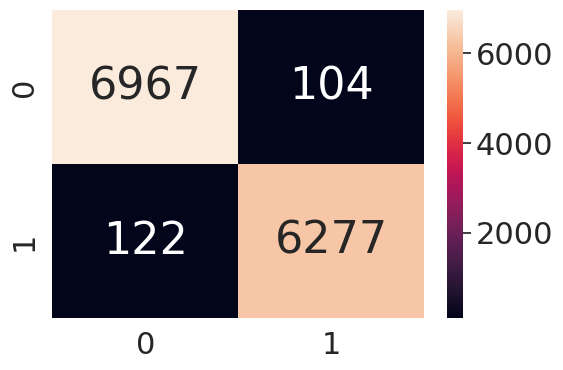

In [14]:
# Predict test dataset
y_test_pred = lr.predict(tfidf_test)

# Print confusion matrix
f = plt.figure(figsize=(6,4))
sb.heatmap(cm:=confusion_matrix(y_test, y_test_pred), annot = True, fmt=".0f", annot_kws={"size": 32})

In [15]:
# Get overall accuracy
print("Test Data")
print("Accuracy  :\t", lr.score(tfidf_test, y_test))
print("")

# Get individual accuracy
tpTest = cm[1][1] # True Positives : Good (1) predicted Good (1)
fpTest = cm[0][1] # False Positives : Bad (0) predicted Good (1)
tnTest = cm[0][0] # True Negatives : Bad (0) predicted Bad (0)
fnTest = cm[1][0] # False Negatives : Good (1) predicted Bad (0)

print("TPR Test :\t", (tpTest/(tpTest + fnTest)))
print("TNR Test :\t", (tnTest/(tnTest + fpTest)))

print("\nFPR Test :\t", (fpTest/(fpTest + tnTest)))
print("FNR Test :\t", (fnTest/(fnTest + tpTest)))

Test Data
Accuracy  :	 0.9832219747587231

TPR Test :	 0.9809345210189092
TNR Test :	 0.9852920379012869

FPR Test :	 0.014707962098713053
FNR Test :	 0.019065478981090796


<Axes: >

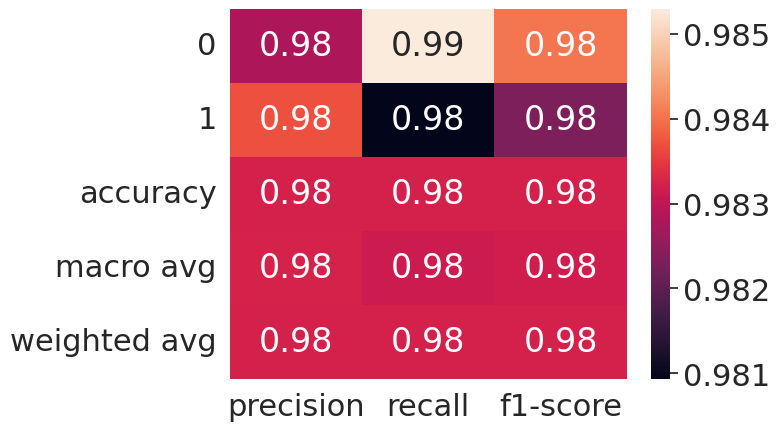

In [16]:
# Print classification report
cr = classification_report(y_test, y_test_pred,output_dict=True)
sb.heatmap(pd.DataFrame(cr).iloc[:-1, :].T, annot=True)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=9f23536d-6e62-418a-b94b-ca9356b2599b' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>